<a href="https://colab.research.google.com/github/Sai6945/21HM1A0526/blob/main/AgeAndGenderDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

In [11]:
from google.colab import files

# Upload the file
uploaded = files.upload()

# Unzip the file
!unzip 'UTKFaceZ.zip' -d '/content/UTKFace'

Streaming output truncated to the last 5000 lines.
  inflating: /content/UTKFace/UTKFace.zip/53_0_1_20170116191725055.jpg.chip.jpg  
  inflating: /content/UTKFace/UTKFace.zip/53_0_1_20170116192938845.jpg.chip.jpg  
  inflating: /content/UTKFace/UTKFace.zip/53_0_1_20170117181950281.jpg.chip.jpg  
  inflating: /content/UTKFace/UTKFace.zip/53_0_1_20170120222553113.jpg.chip.jpg  
  inflating: /content/UTKFace/UTKFace.zip/53_0_1_20170120222956787.jpg.chip.jpg  
  inflating: /content/UTKFace/UTKFace.zip/53_0_1_20170120223004304.jpg.chip.jpg  
  inflating: /content/UTKFace/UTKFace.zip/53_0_2_20170104210010763.jpg.chip.jpg  
  inflating: /content/UTKFace/UTKFace.zip/53_0_2_20170112215433623.jpg.chip.jpg  
  inflating: /content/UTKFace/UTKFace.zip/53_0_2_20170112221930338.jpg.chip.jpg  
  inflating: /content/UTKFace/UTKFace.zip/53_0_2_20170116192925824.jpg.chip.jpg  
  inflating: /content/UTKFace/UTKFace.zip/53_0_2_20170116192934154.jpg.chip.jpg  
  inflating: /content/UTKFace/UTKFace.zip/53_0_

In [12]:
BASE_DIR = '/content/UTKFace/UTKFace.zip'
age_labels = []
gender_labels = []
image_paths = []

image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
  image_path = os.path.join(BASE_DIR, image)
  img_components = image.split('_')
  age_label = int(img_components[0])
  gender_label = int(img_components[1])

  # Append the image_path, age_label, and gender_label
  age_labels.append(age_label)
  gender_labels.append(gender_label)
  image_paths.append(image_path)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [13]:
print(f'Number of age_labels: {len(age_labels)}, Number of gender_labels: {len(gender_labels)}, Number of image_paths: {len(image_paths)}')


Number of age_labels: 23708, Number of gender_labels: 23708, Number of image_paths: 23708


In [14]:
gender_mapping = {
    1: 'Female',
    0: 'Male'
}

In [15]:
import pandas as pd
df = pd.DataFrame()
df['image_path'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head(5)

,image_path,age,gender
0,/content/UTKFace/UTKFace.zip/49_0_0_2017011118...,49,0
1,/content/UTKFace/UTKFace.zip/31_0_2_2017011617...,31,0
2,/content/UTKFace/UTKFace.zip/22_0_3_2017011916...,22,0
3,/content/UTKFace/UTKFace.zip/32_0_0_2017011622...,32,0
4,/content/UTKFace/UTKFace.zip/17_0_0_2017011618...,17,0


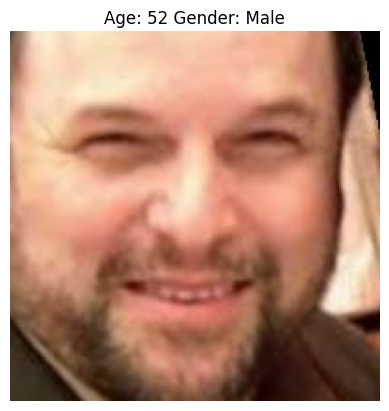

In [16]:
from PIL import Image

rand_index = random.randint(0, len(image_paths))
age = df['age'][rand_index]
gender = df['gender'][rand_index]
IMG = Image.open(df['image_path'][rand_index])
plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
plt.axis('off')
plt.imshow(IMG)

<Axes: xlabel='age', ylabel='Density'>

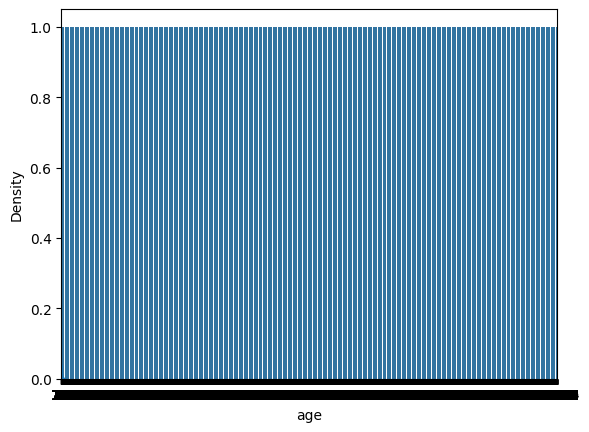

In [17]:
 # Age distribution
 sns.distplot(df['age'])
 sns.countplot(df['gender'])

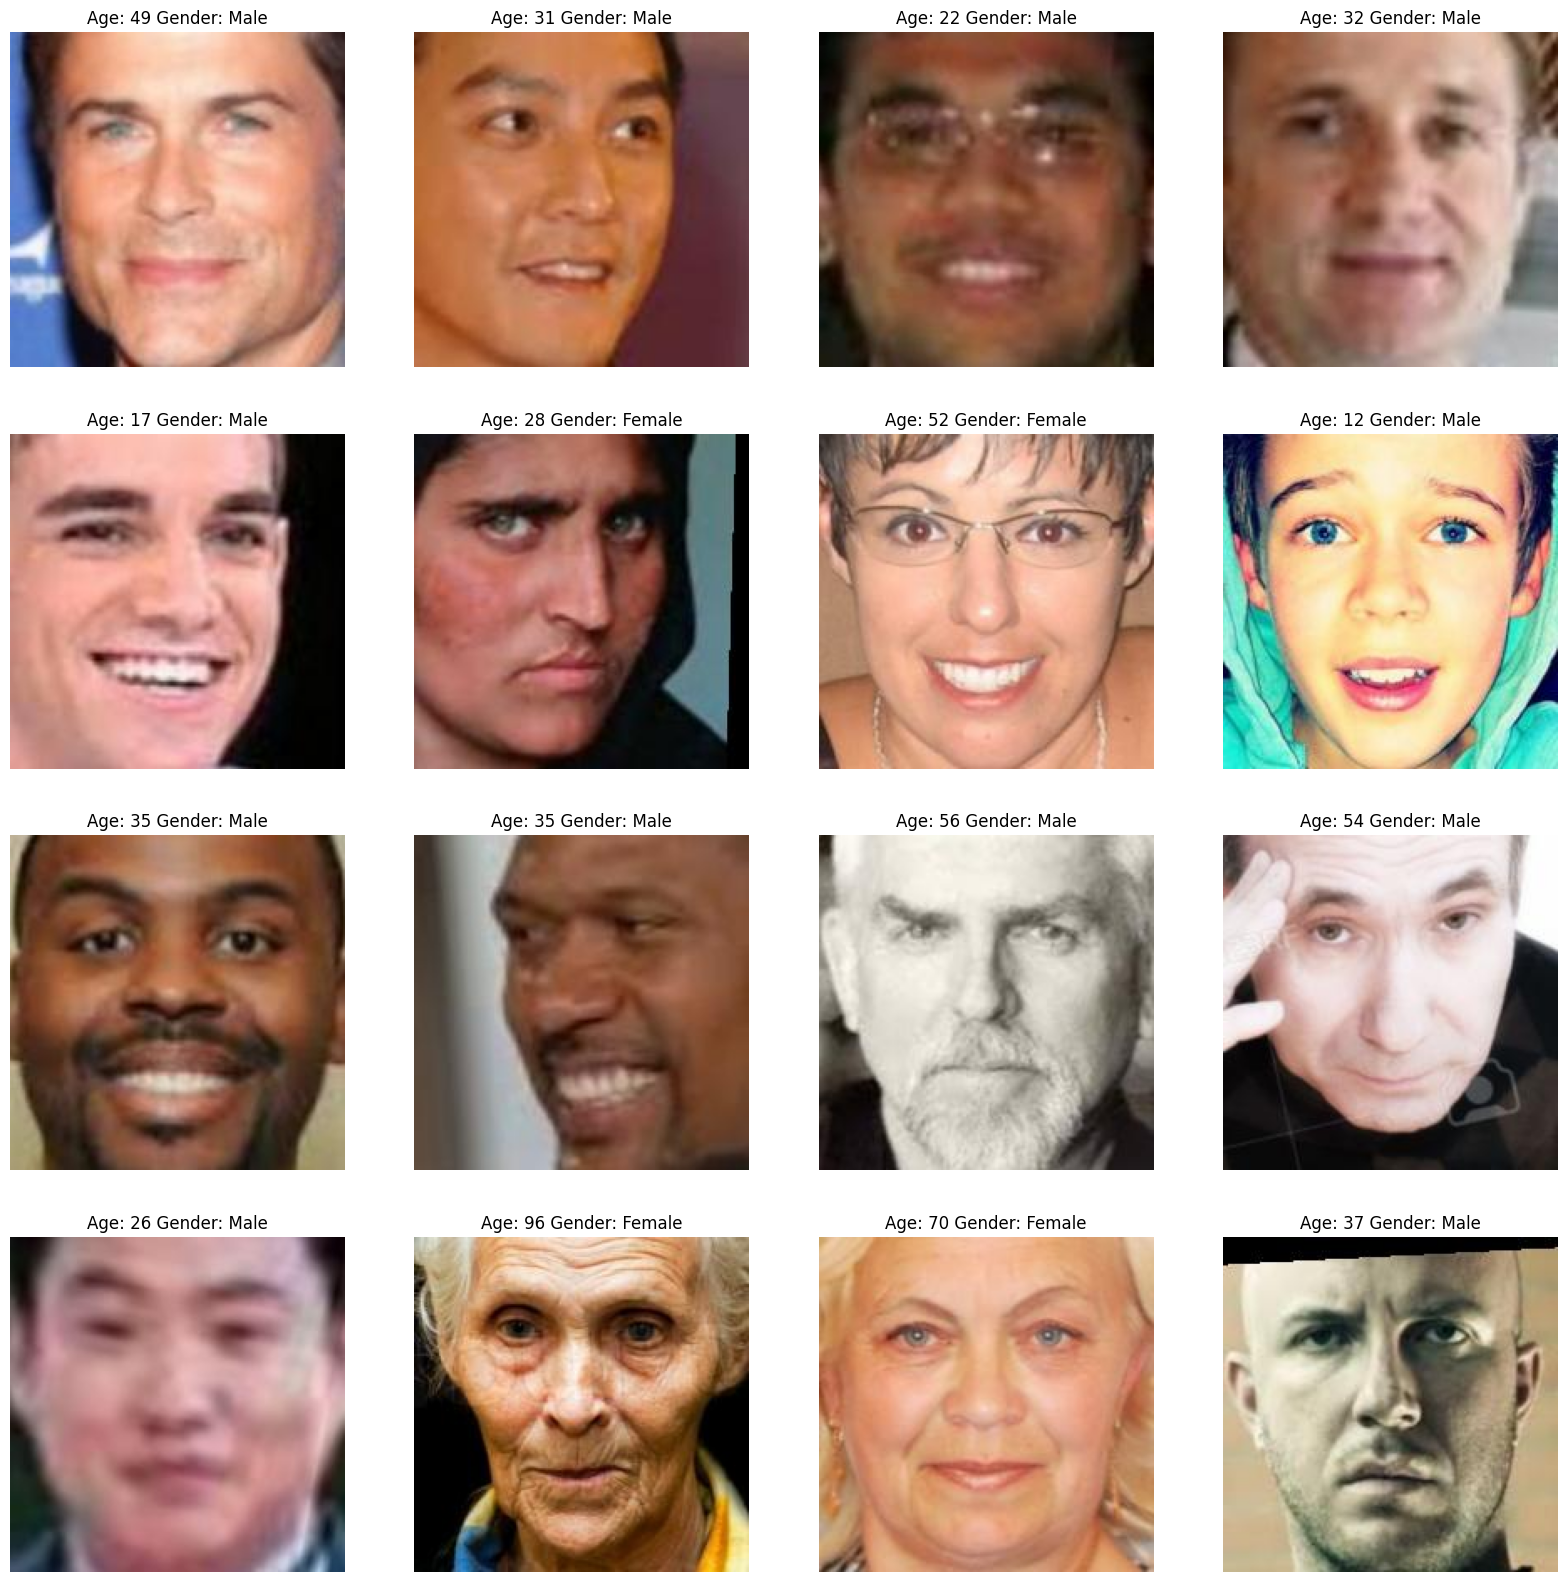

In [18]:
 plt.figure(figsize=(20, 20))
samples = df.iloc[0:16]
for index, sample, age, gender in samples.itertuples():
    plt.subplot(4, 4, index + 1)
    img = load_img(sample)
    img = np.array(img)
    plt.axis('off')
    plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
    plt.imshow(img)

In [3]:
def extract_image_features(images):
    features = list()

    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale', target_size=(128, 128))

        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [5]:
import pandas as pd
df = pd.DataFrame({'image_path': image_paths, 'age': age_labels, 'gender': gender_labels})

X = extract_image_features(df['image_path'])
X.shape
X = X / 255.0
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

NameError: name 'image_paths' is not defined

In [22]:
input_shape = (128, 128, 1)
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

In [23]:
# fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

# Update model.compile to include separate metrics for each output
model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam',
              metrics=[['accuracy'], ['mae']]) # Provide a list of metrics for each output

# ... rest of the code ...


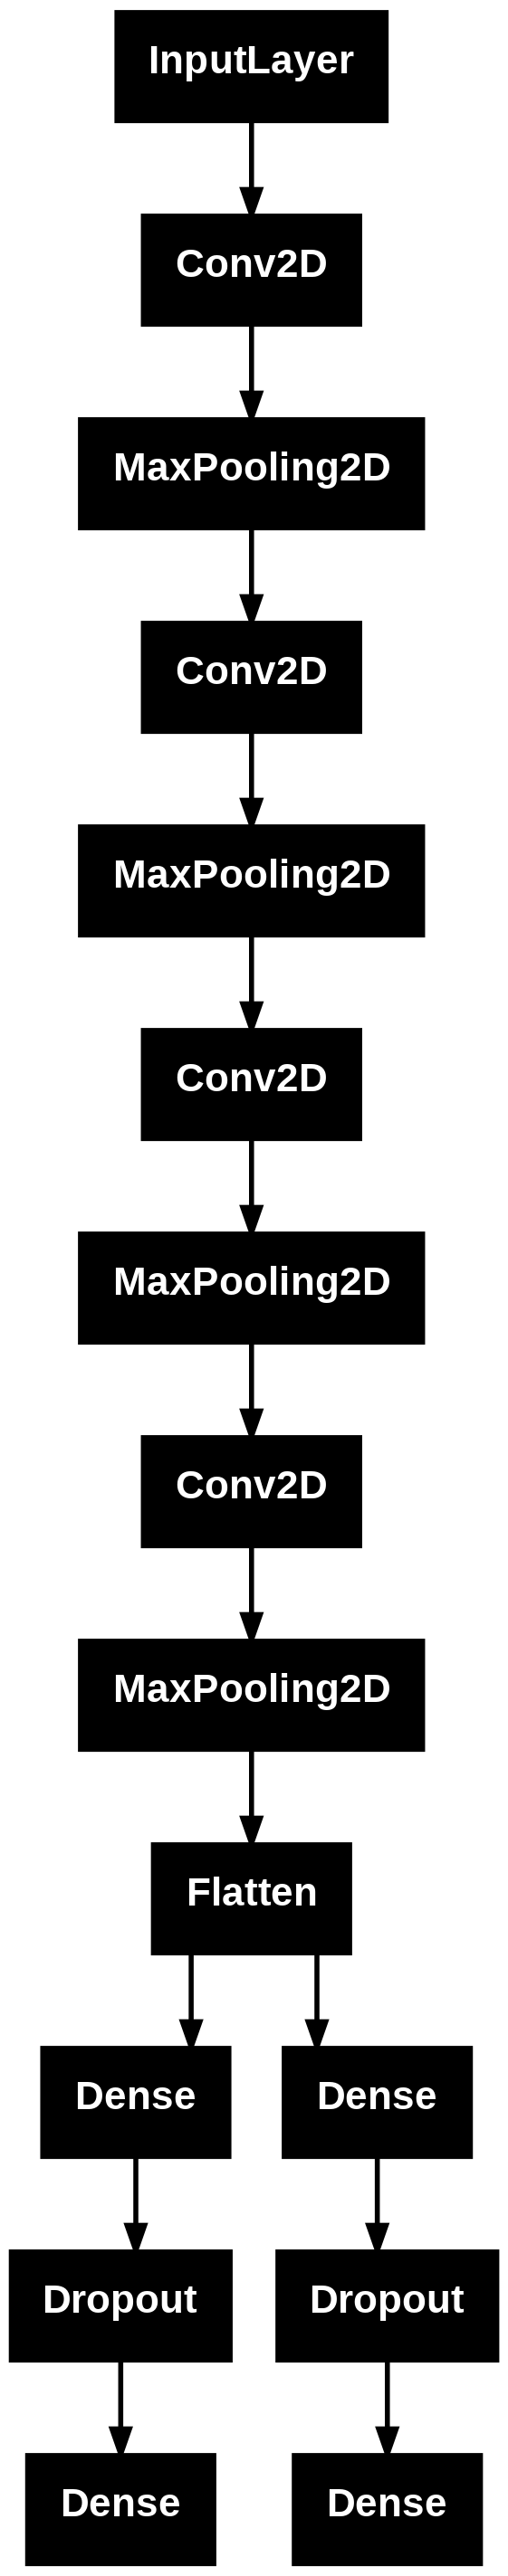

In [24]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)


In [2]:
history = model.fit(x=X, y=[y_gender, y_age],
                    batch_size=32, epochs=50, validation_split=0.2)

NameError: name 'model' is not defined

In [26]:
model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam',
              metrics=[['accuracy'], ['mae']]) # Provide a list of metrics for each output
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

NameError: name 'history' is not defined

In [ ]:
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [ ]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [ ]:
from PIL import Image # Import Image from PIL

def get_image_features(image):
  img = load_img(image) # Remove grayscale=True
  img = img.resize((128, 128)) # Use Image.ANTIALIAS
  img = img.convert('L') # Convert to grayscale using PIL
  img = np.array(img)
  img = img.reshape(1, 128, 128, 1)
  img = img / 255.0
  return img

In [ ]:
img_to_test = '/content/drive/MyDrive/me.jpg'
features = get_image_features(img_to_test)
pred = model.predict(features)
gender = gender_mapping[round(pred[0][0][0])]
age = round(pred[1][0][0])

plt.title(f'Predicted Age: {age} Predicted Gender: {gender}')
plt.axis('off')
plt.imshow(np.array(load_img(img_to_test)))
